In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

In [2]:
tickers = ["TRIDENT.NS", "THEJO.NS", "SPCENET.NS", "SANGINITA.NS", "MITCON.NS"]

end_date = datetime.today()
start_date = end_date - timedelta(days=10 * 256)

close_data = pd.DataFrame()
volume_data = pd.DataFrame()

for ticker in tickers:
    data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)

    base = ticker.replace(".NS", "")
    close_data[f"{base}_Close"] = data['Close']
    volume_data[f"{base}_Volume"] = data['Volume']

df = pd.concat([close_data, volume_data], axis=1)
display(df)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,TRIDENT_Close,THEJO_Close,SPCENET_Close,SANGINITA_Close,MITCON_Close,TRIDENT_Volume,THEJO_Volume,SPCENET_Volume,SANGINITA_Volume,MITCON_Volume
Date,,,,,,,,,,
2018-07-24,4.654171,184.195404,0.20,77.357140,47.475204,4471420,0.0,0.0,6631,11627.0
2018-07-25,4.650004,182.579636,0.20,73.511902,49.112278,1533200,3600.0,0.0,1105,2325.0
2018-07-26,4.679171,182.579636,0.20,69.892860,49.112278,2239940,1800.0,0.0,7736,0.0
2018-07-27,4.600004,182.579636,0.20,66.409523,49.112278,3624700,0.0,0.0,2210,0.0
2018-07-30,4.666669,185.811157,0.20,66.409523,49.112278,3402840,1800.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...
2025-07-21,31.540001,2258.100098,7.19,10.570000,80.570000,5031058,6774.0,231173.0,17840,2072.0
2025-07-22,30.370001,2253.399902,7.04,10.340000,79.980003,11405437,3631.0,266887.0,53330,2536.0
2025-07-23,31.000000,2242.399902,6.89,10.280000,79.300003,6999187,2368.0,246529.0,89667,10954.0


## **Close price**

Columns being plotted: ['TRIDENT_Close', 'THEJO_Close', 'SPCENET_Close', 'SANGINITA_Close', 'MITCON_Close']


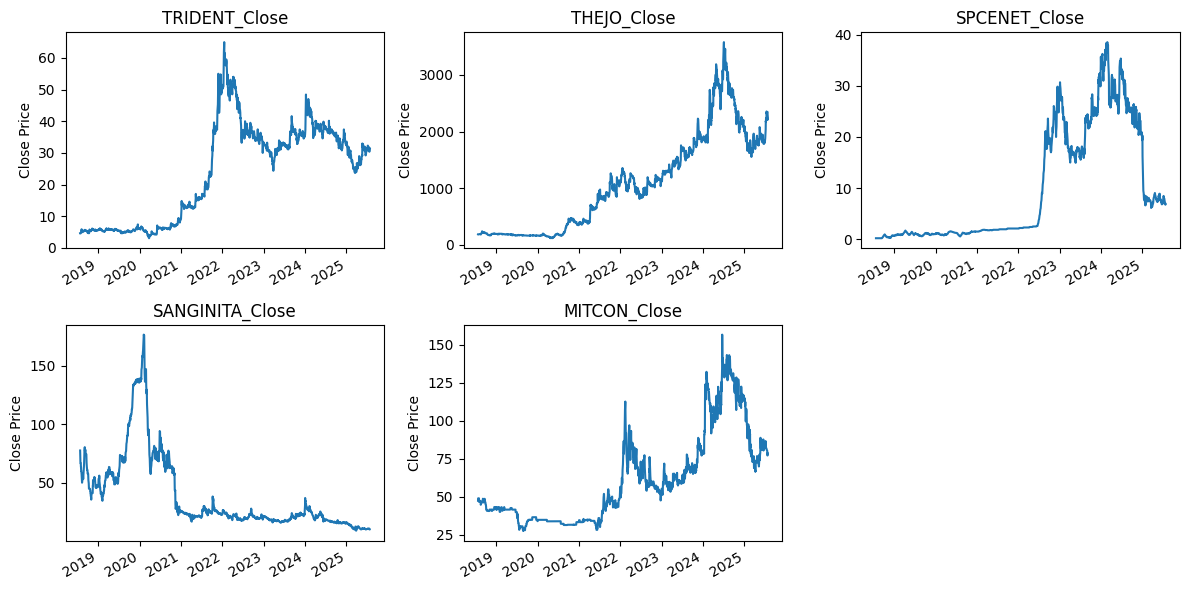

In [3]:
close_columns = [col for col in df.columns if col.endswith('_Close')]

print("Columns being plotted:", close_columns)

n_plots = len(close_columns)
n_rows = (n_plots + 2) // 3

plt.figure(figsize=(12, 6))
plt.subplots_adjust(hspace=0.5)

for i, company in enumerate(close_columns, 1):
    plt.subplot(n_rows, 3, i)
    df[company].plot()
    plt.ylabel('Close Price')
    plt.xlabel(None)
    plt.title(company)

plt.tight_layout()
plt.show()

## **Volume**

Columns being plotted: ['TRIDENT_Close', 'THEJO_Close', 'SPCENET_Close', 'SANGINITA_Close', 'MITCON_Close']


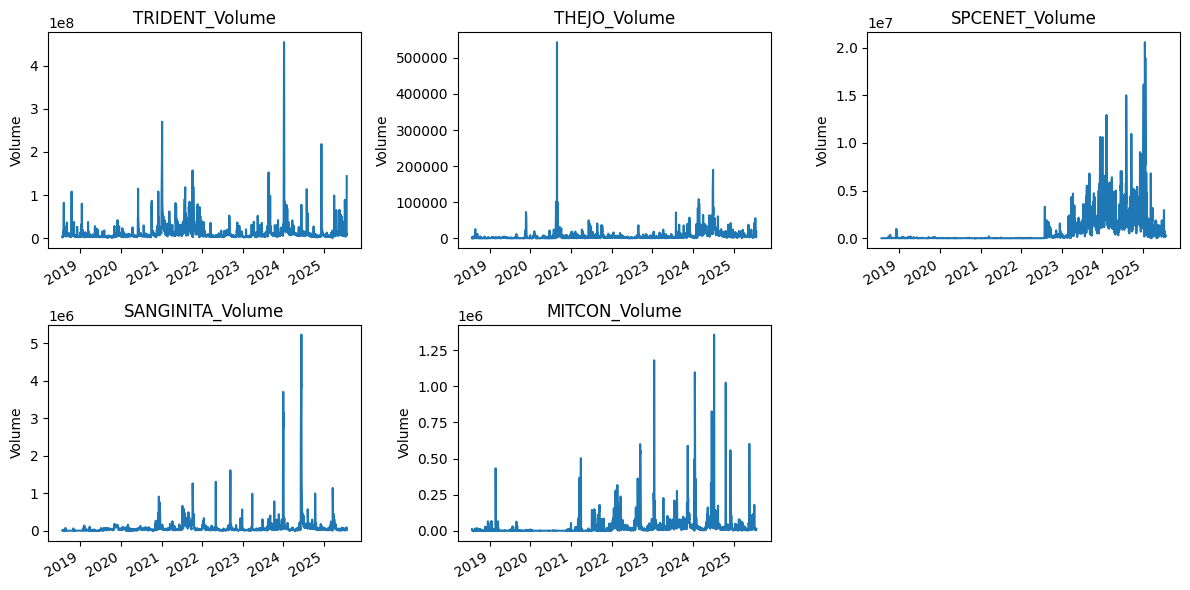

In [4]:
volume_columns = [col for col in df.columns if col.endswith('_Volume')]

print("Columns being plotted:", close_columns)

n_plots = len(volume_columns)
n_rows = (n_plots + 2) // 3
plt.figure(figsize=(12, 6))
plt.subplots_adjust(hspace=0.5)

for i, company in enumerate(volume_columns, 1):
    plt.subplot(n_rows, 3, i)
    df[company].plot()
    plt.ylabel('Volume')
    plt.xlabel(None)
    plt.title(company)

plt.tight_layout()
plt.show()

## **Moving averages**

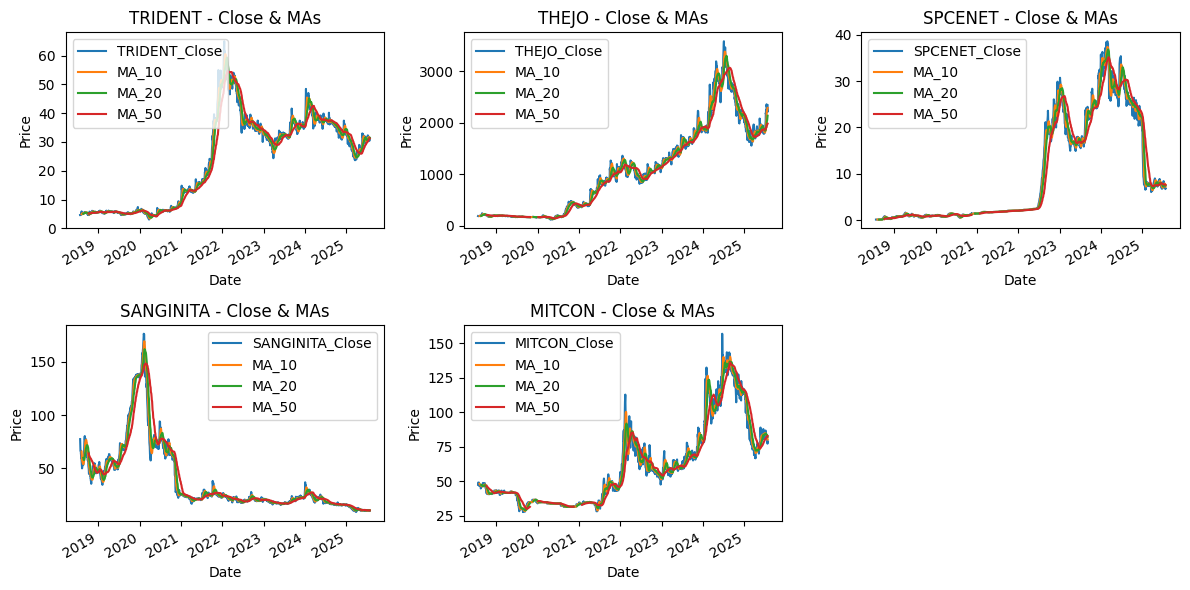

In [5]:
ma_days = [10, 20, 50]

close_dfs = [df[col].to_frame() for col in close_columns]

for company_df in close_dfs:
    for ma in ma_days:
        company_df[f"MA_{ma}"] = company_df.iloc[:, 0].rolling(ma).mean()

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))

for i, (company_df, ax) in enumerate(zip(close_dfs, axes.flatten())):
    company_df.plot(ax=ax)
    ticker_name = tickers[i].replace(".NS", "")  # Clean label
    ax.set_title(f"{ticker_name} - Close & MAs")
    ax.set_ylabel("Price")
    ax.set_xlabel("Date")

if len(close_dfs) < 6:
    fig.delaxes(axes.flatten()[5])

fig.tight_layout()
plt.show()

## **Daily returns**

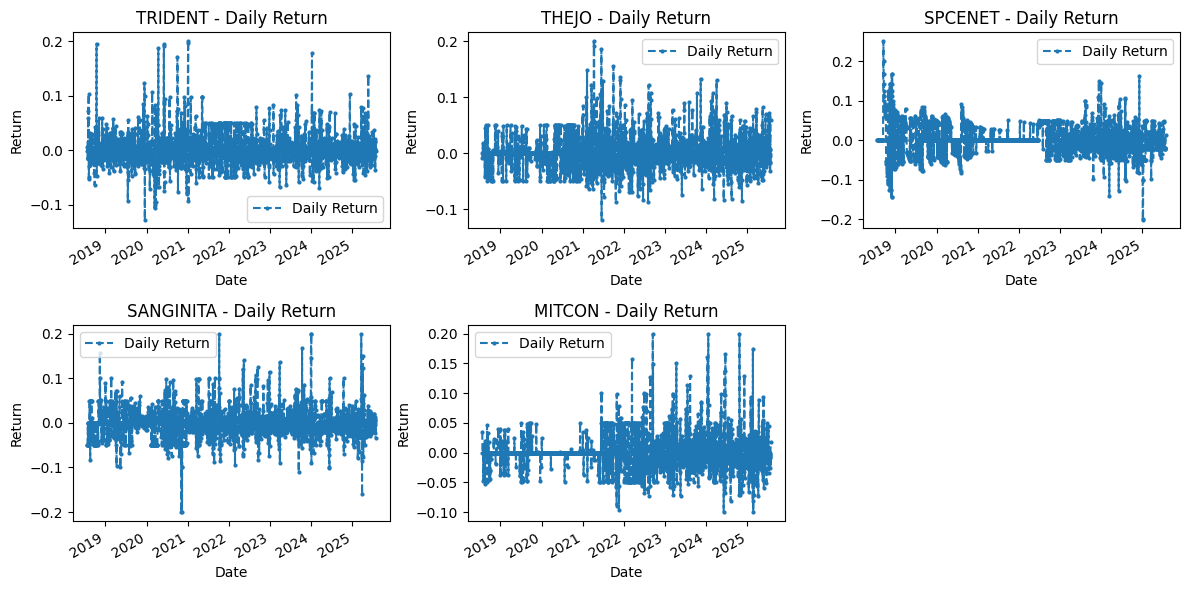

In [6]:
for company_df in close_dfs:
    close_col = company_df.columns[0]
    company_df['Daily Return'] = company_df[close_col].pct_change(fill_method=None)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))

for i, (company_df, ax) in enumerate(zip(close_dfs, axes.flatten())):
    company_df['Daily Return'].plot(ax=ax, legend=True, linestyle='--', marker='o', markersize=2)
    ticker_name = tickers[i].replace(".NS", "")
    ax.set_title(f"{ticker_name} - Daily Return")
    ax.set_ylabel("Return")
    ax.set_xlabel("Date")

if len(close_dfs) < 6:
    fig.delaxes(axes.flatten()[5])

fig.tight_layout()
plt.show()

## **Correlation**

In [7]:
returns_list = []

for company_df in close_dfs:
    close_col = company_df.columns[0]
    daily_returns = company_df[close_col].pct_change(fill_method=None)
    ticker_name = close_col.replace("_Close", "")
    returns_list.append(daily_returns.rename(ticker_name))

returns_df = pd.concat(returns_list, axis=1)

correlation_matrix = returns_df.corr()

print("Correlation matrix of daily returns:")
print(correlation_matrix)

Correlation matrix of daily returns:
            TRIDENT     THEJO   SPCENET  SANGINITA    MITCON
TRIDENT    1.000000  0.144523  0.079679   0.119513  0.089886
THEJO      0.144523  1.000000  0.064792   0.083630  0.070416
SPCENET    0.079679  0.064792  1.000000   0.059955  0.072355
SANGINITA  0.119513  0.083630  0.059955   1.000000  0.083909
MITCON     0.089886  0.070416  0.072355   0.083909  1.000000


## **How much value do we put at risk by investing in a particular stock?**

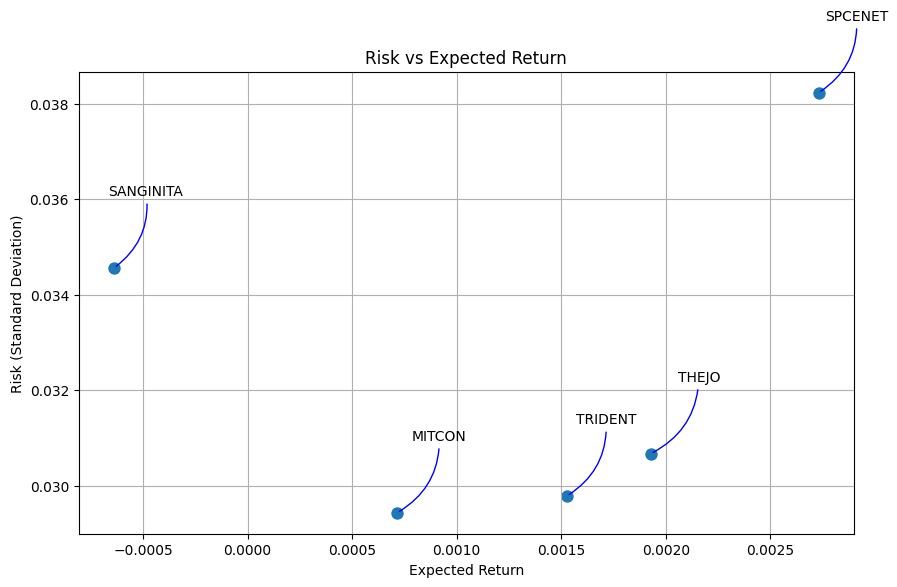

In [8]:
rets = returns_df.dropna()
area = np.pi * 20

plt.figure(figsize=(10, 6))
plt.scatter(rets.mean(), rets.std(), s=area)

plt.xlabel('Expected Return')
plt.ylabel('Risk (Standard Deviation)')
plt.title('Risk vs Expected Return')

for label, x, y in zip(rets.columns, rets.mean(), rets.std()):
  plt.annotate(label, xy=(x, y),
               xytext=(50, 50),
               textcoords='offset points',
               ha='right',
               va='bottom',
               arrowprops=dict(arrowstyle='-',
                               color='blue',
                               connectionstyle='arc3,rad=-0.3'))

plt.grid(True)
plt.show()

In [9]:
tickers = ["TRIDENT.NS"]  # You can change or loop multiple stocks here
end_date = datetime.today()
start_date = end_date - timedelta(days=10 * 256)

data = yf.download(tickers[0], start=start_date, end=end_date, auto_adjust=True)
df = data[['Close', 'Volume']].copy()

[*********************100%***********************]  1 of 1 completed


## **Data standardization**

In [10]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

## **sequences for LSTM input**

In [11]:
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

## **train and test sets**

In [12]:
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

mse_list, rmse_list, mae_list, r2_list = [], [], [], []

for fold, (train_index, test_index) in enumerate(tscv.split(X)):
    print(f"\nFold {fold + 1}/{n_splits}")
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]


Fold 1/5

Fold 2/5

Fold 3/5

Fold 4/5

Fold 5/5


## **Build and Train the LSTM Model**

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - loss: 0.0324 - val_loss: 5.0108e-04
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - loss: 0.0019 - val_loss: 8.8273e-04
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - loss: 0.0019 - val_loss: 6.9282e-04
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - loss: 0.0019 - val_loss: 0.0015


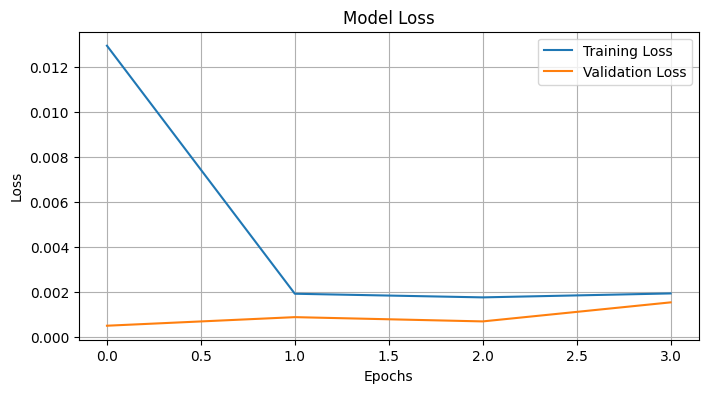

In [13]:
from tensorflow.keras.layers import Input, Dropout

model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(100, return_sequences=True),
    Dropout(0.2),
    LSTM(100),
    Dropout(0.2),
    Dense(1)])

model.compile(optimizer='adam', loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=3,
                               restore_best_weights=True)

history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'],
         label='Training Loss')
plt.plot(history.history['val_loss'],
         label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

## **Predictions and Evaluate the Model**

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
Mean Squared Error (MSE): 1.9214
Root Mean Squared Error (RMSE): 1.3862
Mean Absolute Error (MAE): 1.0094
R² Score: 0.8811


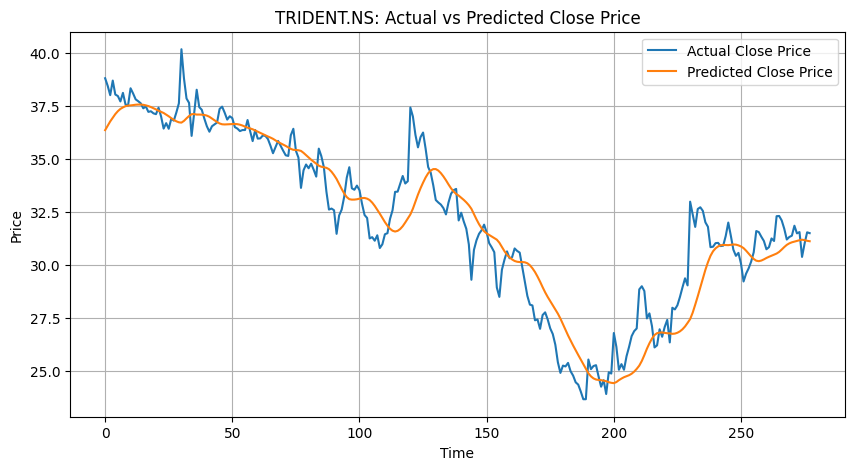

In [14]:
y_pred_scaled = model.predict(X_test)

y_pred_full = np.hstack((y_pred_scaled, np.zeros_like(y_pred_scaled)))
y_test_full = np.hstack((y_test.reshape(-1, 1), np.zeros_like(y_test.reshape(-1, 1))))

y_pred = scaler.inverse_transform(y_pred_full)[:, 0]
y_true = scaler.inverse_transform(y_test_full)[:, 0]

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(y_true, label='Actual Close Price')
plt.plot(y_pred, label='Predicted Close Price')
plt.title(f"{tickers[0]}: Actual vs Predicted Close Price")
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

## **Forward forecast**

In [15]:
last_sequence = scaled_data[-seq_length:]
current_sequence = last_sequence.reshape(1, seq_length, 2)

future_days = 22
future_predictions = []

for _ in range(future_days):
    next_pred_scaled = model.predict(current_sequence)[0, 0]
    next_input = np.array([[next_pred_scaled, 0]])
    current_sequence = np.append(current_sequence[:, 1:, :],
                                 next_input.reshape(1, 1, 2),
                                 axis=1)
    future_predictions.append(next_pred_scaled)

future_scaled = np.array(future_predictions).reshape(-1, 1)
dummy_volume = np.zeros_like(future_scaled)
future_combined = np.hstack((future_scaled, dummy_volume))
predicted_close_prices = scaler.inverse_transform(future_combined)[:, 0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


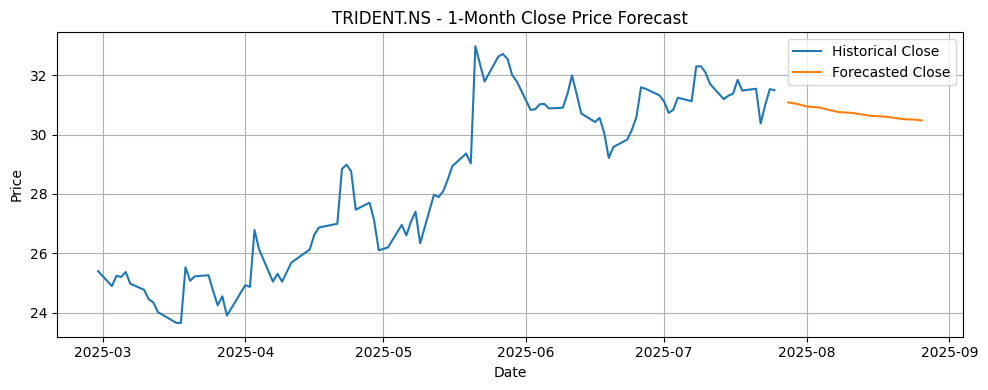

In [16]:
last_date = df.index[-1]
future_dates = pd.bdate_range(last_date + timedelta(days=1), periods=future_days)

plt.figure(figsize=(10, 4))
plt.plot(df.index[-100:], df['Close'][-100:], label='Historical Close')
plt.plot(future_dates, predicted_close_prices, label='Forecasted Close')
plt.title(f'{tickers[0]} - 1-Month Close Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [17]:
predicted_close_prices

array([31.080244, 31.056644, 31.025558, 30.987537, 30.945566, 30.902748,
       30.86135 , 30.822687, 30.787298, 30.755136, 30.725885, 30.699015,
       30.674004, 30.650333, 30.62759 , 30.605415, 30.583542, 30.561766,
       30.539951, 30.51801 , 30.495897, 30.473583], dtype=float32)